Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
(10000, 3072) (1000, 3072)
Got 296 / 1000 correct with k=5 => accuracy: 0.296000


k = 100: 100%|██████████| 5/5 [16:46<00:00, 201.21s/it]


Printing our 5-fold accuracies for varying values of k:

k = 1, accuracy = 0.288500
k = 1, accuracy = 0.284000
k = 1, accuracy = 0.282500
k = 1, accuracy = 0.274500
k = 1, accuracy = 0.277000
k = 3, accuracy = 0.287500
k = 3, accuracy = 0.274000
k = 3, accuracy = 0.278500
k = 3, accuracy = 0.267500
k = 3, accuracy = 0.265500
k = 5, accuracy = 0.294500
k = 5, accuracy = 0.284000
k = 5, accuracy = 0.297500
k = 5, accuracy = 0.275000
k = 5, accuracy = 0.278500
k = 8, accuracy = 0.298500
k = 8, accuracy = 0.296000
k = 8, accuracy = 0.284000
k = 8, accuracy = 0.274000
k = 8, accuracy = 0.286000
k = 10, accuracy = 0.302500
k = 10, accuracy = 0.287000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.266000
k = 10, accuracy = 0.285000
k = 12, accuracy = 0.304500
k = 12, accuracy = 0.293500
k = 12, accuracy = 0.285500
k = 12, accuracy = 0.265000
k = 12, accuracy = 0.275500
k = 15, accuracy = 0.294000
k = 15, accuracy = 0.297000
k = 15, accuracy = 0.275000
k = 15, accuracy = 0.274000
k = 15, acc

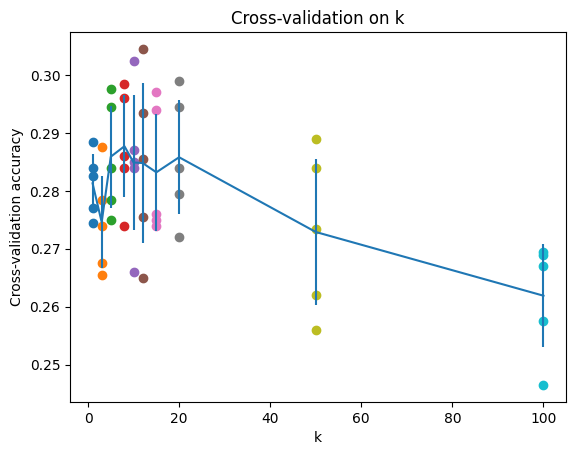

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, r'D:\9th semester\git\ML_Spring_23_24\Mid\assignments\KNN-HW')  # Insert the path to the directory containing data_utils.py
import data_utils
import download
from tqdm import tqdm

def download_data():
    pass

# Class to initialize and apply K-nearest neighbour classifier
class KNearestNeighbor(object):
    def __init__(self):
        pass

    # Method to initialize classifier with training data
    def train(self, X, y):
        self.X_train = X
        self.y_train = y
    
    # Method to predict labels of test examples using 'compute_distances' and 'predict_labels' methods.
    def predict(self, X, k=1, num_loops=0):
        if num_loops == 0:
            dists = self.compute_distances(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)
        return self.predict_labels(dists, k=k)

    # Method to compute Euclidean distances from each text example to every training example  
    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        # Compute distances from each test example to every training example
        for i in range(num_test):
            for j in range(num_train):
                dists[i, j] = np.sqrt(np.sum((X[i] - self.X_train[j]) ** 2))
        return dists

    # Method to predict labels of test examples using chosen value of k given Euclidean distances obtained from 'compute_distances' method.
    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        # Predict labels using k nearest neighbors
        for i in range(num_test):
            closest_y = self.y_train[np.argsort(dists[i])[:k]]
            y_pred[i] = np.argmax(np.bincount(closest_y))
        return y_pred

def visualize_data(X_train, y_train):
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    num_classes = len(classes)
    samples_per_class = 7
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()

if __name__ == "__main__":

    # Download CIFAR10 data and store it in current directory if you have not done it.
    #download_data()
    cifar10_dir = r'D:/9th semester/git/ML_Spring_23_24/Mid/assignments/KNN-HW/cifar-10-batches-py'

    # Load training and testing data from CIFAR10 dataset
    X_train, y_train, X_test, y_test = data_utils.load_CIFAR10(cifar10_dir)

    # Checking the size of the training and testing data
    print('Training data shape: ', X_train.shape)
    print('Training labels shape: ', y_train.shape)
    print('Test data shape: ', X_test.shape)
    print('Test labels shape: ', y_test.shape)

    # Visualize the data if you want
    # visualize_data(X_train, y_train)

    # Memory error prevention by subsampling data. We sample 10000 training examples and 1000 test examples.
    num_training = 10000
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]

    num_test = 1000
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Reshape data and place into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    print(X_train.shape, X_test.shape)  # X_train should be (10000, 3072) and X_test should be (1000, 3072)

    # Performing KNN
    classifier = KNearestNeighbor()

    # Train the classifier
    classifier.train(X_train, y_train)

    # Predict labels for test data
    y_test_pred = classifier.predict(X_test, k=5)

    # Compute and print the fraction of correctly predicted examples
    num_correct = np.sum(y_test_pred == y_test)
    accuracy = float(num_correct) / num_test
    print('Got %d / %d correct with k=5 => accuracy: %f' % (num_correct, num_test, accuracy))
    # Accuracy above should be ~ 29-30%

    # Perform 5-fold cross validation to find optimal k from choices below
    num_folds = 5
    k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

    X_train_folds = np.array_split(X_train, num_folds)
    y_train_folds = np.array_split(y_train, num_folds)
    k_to_accuracies = {}  # dictionary to hold validation accuracies for each k 

    # Loop over the k values
    for k in k_choices:
        k_to_accuracies[k] = []  # each key, k, should hold its list of 5 validation accuracies

        # Loop over the folds
        for fold in tqdm(range(num_folds), desc=f'k = {k}'):
            # Get the training and validation data for this fold
            X_train_fold = np.concatenate([f for i, f in enumerate(X_train_folds) if i != fold])
            y_train_fold = np.concatenate([f for i, f in enumerate(y_train_folds) if i != fold])
            X_val_fold = X_train_folds[fold]
            y_val_fold = y_train_folds[fold]

            # Train the classifier
            classifier.train(X_train_fold, y_train_fold)

            # Predict labels for the validation data
            y_val_pred = classifier.predict(X_val_fold, k=k)

            # Compute and store the accuracy for this fold
            num_correct = np.sum(y_val_pred == y_val_fold)
            accuracy = float(num_correct) / len(y_val_fold)
            k_to_accuracies[k].append(accuracy)

    print("Printing our 5-fold accuracies for varying values of k:")
    print()
    for k in sorted(k_to_accuracies):
        for accuracy in k_to_accuracies[k]:
            print('k = %d, accuracy = %f' % (k, accuracy))
    
    for k in sorted(k_to_accuracies):
        print('k = %d, avg. accuracy = %f' % (k, sum(k_to_accuracies[k]) / num_folds))
    
    for k in k_choices:
        accuracies = k_to_accuracies[k]
        plt.scatter([k] * len(accuracies), accuracies)

    # Plot the trend line with error bars that correspond to standard deviation
    accuracies_mean = np.array([np.mean(v) for k, v in sorted(k_to_accuracies.items())])
    accuracies_std = np.array([np.std(v) for k, v in sorted(k_to_accuracies.items())])
    plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
    plt.title('Cross-validation on k')
    plt.xlabel('k')
    plt.ylabel('Cross-validation accuracy')
    plt.savefig('cross-validation_accuracy.jpg')

    # Choose best value of k based on cross-validation results
    best_k = k_choices[np.argmax(accuracies_mean)]

    # Train the classifier with the full training data
    classifier.train(X_train, y_train)

    # Predict labels of test data using the best value of k
    y_test_pred = classifier.predict(X_test, k=best_k)

    # Computing and displaying the accuracy for best k found during cross-validation
    num_correct = np.sum(y_test_pred == y_test)
    accuracy = float(num_correct) / num_test
    print('Got %d / %d correct on test data => accuracy: %f' % (num_correct, num_test, accuracy))
    # Accuracy above should be ~ 57-58%
